In [1]:
!pip install rdkit -q

In [2]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem, Draw, Descriptors
from rdkit.Chem.Draw import IPythonConsole
from sklearn.preprocessing import FunctionTransformer


import pandas as pd
import numpy as np
from rdkit import Chem, DataStructs
from rdkit.Chem import Descriptors, AllChem
from tqdm.notebook import tqdm

import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer

from transformers import BertTokenizer, BertForMaskedLM, BertConfig
from transformers import Trainer, TrainingArguments

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

2024-05-28 06:28:57.299096: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-28 06:28:57.299197: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-28 06:28:57.469283: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Baseline

In [3]:
data = pd.read_excel('/kaggle/input/ml-2-hw/19_35000.xlsx')
data.drop('Unnamed: 0', axis=1, inplace=True)
data.drop_duplicates(inplace=True)
print(data.shape)
data.head()

(36368, 3)


,Title,IC50,SMILES
0,CHEMBL2206459,0.000015,[H]\N=C(N)\N[C@@H](C1)[C@@H](NC(=O)C)[C@@H](C=...
1,CHEMBL3818159,0.000016,O=C(O)C1=C[C@H](N)[C@@H](NC(=O)C)[C@@H](C1)COC...
2,CHEMBL1956716,0.000033,C=CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O...
3,CHEMBL1956715,0.000032,CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O)O...
4,CHEMBL4444029,0.000041,O=C(O)c1c(O)c(=O)cc([nH]1)-c(c2C)ccc(c2)-c3noc...


In [4]:
def mol_dsc_calc(mols):
    return pd.DataFrame({k: f(Chem.MolFromSmiles(m)) for k, f in descriptors.items()} for m in mols)

# список конституционных и физико-химических дескрипторов из библиотеки RDKit
descriptors = {"HeavyAtomCount": Descriptors.HeavyAtomCount,
               "NHOHCount": Descriptors.NHOHCount,
               "NOCount": Descriptors.NOCount,
               "NumHAcceptors": Descriptors.NumHAcceptors,
               "NumHDonors": Descriptors.NumHDonors,
               "NumHeteroatoms": Descriptors.NumHeteroatoms,
               "NumRotatableBonds": Descriptors.NumRotatableBonds,
               "NumValenceElectrons": Descriptors.NumValenceElectrons,
               "NumAromaticRings": Descriptors.NumAromaticRings,
               "NumAliphaticHeterocycles": Descriptors.NumAliphaticHeterocycles,
               "RingCount": Descriptors.RingCount,
               "MW": Descriptors.MolWt,
               "LogP": Descriptors.MolLogP,
               "MR": Descriptors.MolMR,
               "TPSA": Descriptors.TPSA}

def rdkit_fp(smiles_column: pd.Series, radius=3, nBits=2048, useChirality=False):
    # morganFP_rdkit
    def desc_gen(mol):
        mol = Chem.MolFromSmiles(mol)
        bit_vec = np.zeros((1,), np.int16)
        DataStructs.ConvertToNumpyArray(
            AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=nBits, useChirality=useChirality), bit_vec)
        return bit_vec

    return pd.DataFrame.from_records(smiles_column.apply(func=desc_gen), columns=[f'bit_id_{i}' for i in range(nBits)])


def rdkit_2d(smiles_column: pd.Series):
    # 2d_rdkit
    descriptors = {i[0]: i[1] for i in Descriptors._descList}
    return pd.DataFrame({k: f(Chem.MolFromSmiles(m)) for k, f in descriptors.items()} for m in smiles_column)

In [ ]:
# sklearn трансформер для использования в конвейерном моделировании
descriptors_transformer = FunctionTransformer(mol_dsc_calc)
X = descriptors_transformer.transform(data['SMILES'])
X.head()

In [5]:
data_dsc = data.join(X)
data_dsc = data_dsc.dropna()

In [8]:
# data_dsc.to_csv('data_dsc.csv', index=False)
data_dsc = pd.read_csv('/kaggle/input/ml-2-hw/data_dsc.csv')

In [11]:
data_dsc.shape

(36359, 18)

In [12]:
data_dsc.head()

,Title,IC50,SMILES,HeavyAtomCount,NHOHCount,NOCount,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,NumAliphaticHeterocycles,RingCount,MW,LogP,MR,TPSA
0,CHEMBL2206459,0.000015,[H]\N=C(N)\N[C@@H](C1)[C@@H](NC(=O)C)[C@@H](C=...,24.0,7.0,9.0,4.0,6.0,10.0,7.0,138.0,0.0,0.0,1.0,362.367,0.38187,90.4296,157.76
1,CHEMBL3818159,0.000016,O=C(O)C1=C[C@H](N)[C@@H](NC(=O)C)[C@@H](C1)COC...,21.0,4.0,6.0,4.0,3.0,6.0,7.0,120.0,0.0,0.0,1.0,298.383,1.05450,79.7279,101.65
2,CHEMBL1956716,0.000033,C=CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O...,21.0,3.0,6.0,5.0,2.0,6.0,7.0,118.0,0.0,0.0,1.0,295.359,-0.36170,77.0531,104.48
3,CHEMBL1956715,0.000032,CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O)O...,20.0,3.0,6.0,5.0,2.0,6.0,6.0,114.0,0.0,0.0,1.0,283.348,-0.52780,72.5301,104.48
4,CHEMBL4444029,0.000041,O=C(O)c1c(O)c(=O)cc([nH]1)-c(c2C)ccc(c2)-c3noc...,24.0,4.0,9.0,6.0,4.0,9.0,3.0,122.0,3.0,0.0,3.0,329.268,1.09742,81.9775,149.28


In [17]:
Y = rdkit_fp(data_dsc['SMILES'])
Y

[20:18:34] Conflicting single bond directions around double bond at index 55.
[20:18:34]   BondStereo set to STEREONONE and single bond directions set to NONE.
[20:18:50] Conflicting single bond directions around double bond at index 7.
[20:18:50]   BondStereo set to STEREONONE and single bond directions set to NONE.


,bit_id_0,bit_id_1,bit_id_2,bit_id_3,bit_id_4,bit_id_5,bit_id_6,bit_id_7,bit_id_8,bit_id_9,...,bit_id_2038,bit_id_2039,bit_id_2040,bit_id_2041,bit_id_2042,bit_id_2043,bit_id_2044,bit_id_2045,bit_id_2046,bit_id_2047
0,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36354,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36355,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36356,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36357,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
data_fp = data_dsc.join(Y)
data_fp.head()

,Title,IC50,SMILES,HeavyAtomCount,NHOHCount,NOCount,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,...,bit_id_2038,bit_id_2039,bit_id_2040,bit_id_2041,bit_id_2042,bit_id_2043,bit_id_2044,bit_id_2045,bit_id_2046,bit_id_2047
0,CHEMBL2206459,0.000015,[H]\N=C(N)\N[C@@H](C1)[C@@H](NC(=O)C)[C@@H](C=...,24.0,7.0,9.0,4.0,6.0,10.0,7.0,...,1,0,0,0,0,0,0,0,0,0
1,CHEMBL3818159,0.000016,O=C(O)C1=C[C@H](N)[C@@H](NC(=O)C)[C@@H](C1)COC...,21.0,4.0,6.0,4.0,3.0,6.0,7.0,...,0,0,0,0,0,0,0,0,0,0
2,CHEMBL1956716,0.000033,C=CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O...,21.0,3.0,6.0,5.0,2.0,6.0,7.0,...,0,0,0,0,0,0,0,0,0,0
3,CHEMBL1956715,0.000032,CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O)O...,20.0,3.0,6.0,5.0,2.0,6.0,6.0,...,0,0,0,0,0,0,0,0,0,0
4,CHEMBL4444029,0.000041,O=C(O)c1c(O)c(=O)cc([nH]1)-c(c2C)ccc(c2)-c3noc...,24.0,4.0,9.0,6.0,4.0,9.0,3.0,...,0,0,0,0,0,0,0,0,0,0


# Clean IC50

In [3]:
# data_fp.to_csv('data_fp.csv', index=False)
data_fp = pd.read_csv('/kaggle/input/ml-2-hw/data_fp.csv')

In [4]:
data_fp.shape

(36359, 2066)

In [5]:
data_fp.head()

,Title,IC50,SMILES,HeavyAtomCount,NHOHCount,NOCount,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,...,bit_id_2038,bit_id_2039,bit_id_2040,bit_id_2041,bit_id_2042,bit_id_2043,bit_id_2044,bit_id_2045,bit_id_2046,bit_id_2047
0,CHEMBL2206459,0.000015,[H]\N=C(N)\N[C@@H](C1)[C@@H](NC(=O)C)[C@@H](C=...,24.0,7.0,9.0,4.0,6.0,10.0,7.0,...,1,0,0,0,0,0,0,0,0,0
1,CHEMBL3818159,0.000016,O=C(O)C1=C[C@H](N)[C@@H](NC(=O)C)[C@@H](C1)COC...,21.0,4.0,6.0,4.0,3.0,6.0,7.0,...,0,0,0,0,0,0,0,0,0,0
2,CHEMBL1956716,0.000033,C=CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O...,21.0,3.0,6.0,5.0,2.0,6.0,7.0,...,0,0,0,0,0,0,0,0,0,0
3,CHEMBL1956715,0.000032,CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O)O...,20.0,3.0,6.0,5.0,2.0,6.0,6.0,...,0,0,0,0,0,0,0,0,0,0
4,CHEMBL4444029,0.000041,O=C(O)c1c(O)c(=O)cc([nH]1)-c(c2C)ccc(c2)-c3noc...,24.0,4.0,9.0,6.0,4.0,9.0,3.0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
print(f"min: {data_fp['IC50'].min()}\nmax: {data_fp['IC50'].max()}")

min: 9.97e-06
max: 1349.48


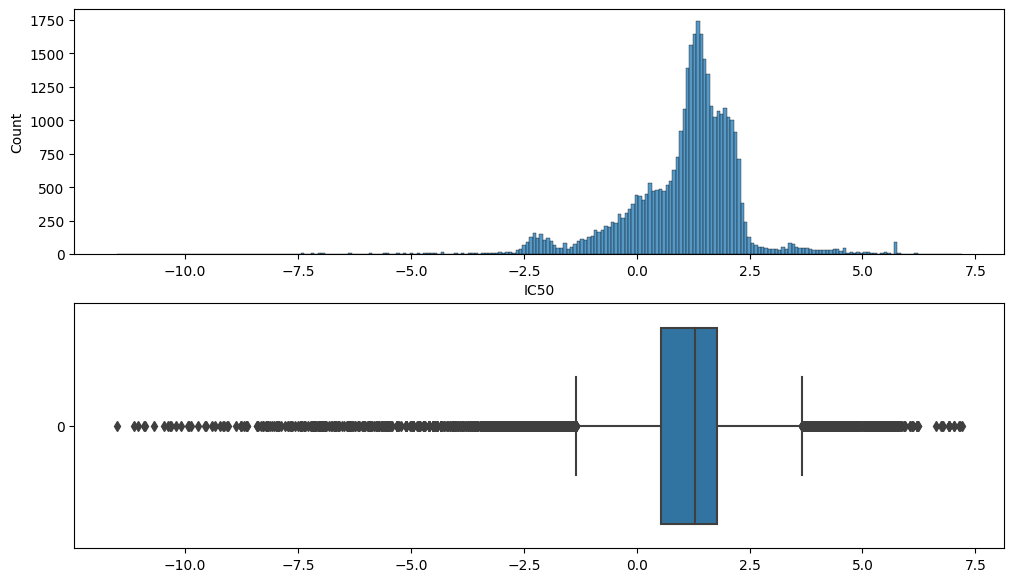

In [7]:
plt.figure(figsize=(12, 7))
plt.subplot(2, 1, 1)
sns.histplot(np.log(data_fp['IC50']))
plt.subplot(2, 1, 2)
sns.boxplot(np.log(data_fp['IC50']), orient='horizontal');

<Axes: xlabel='IC50', ylabel='Count'>

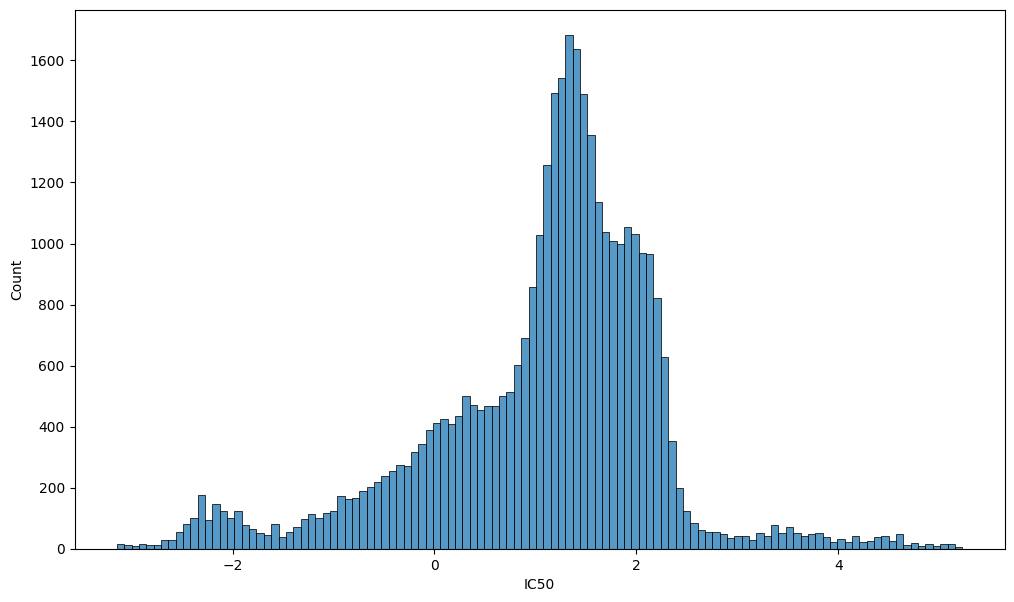

In [8]:
z_scores = stats.zscore(np.log(data_fp['IC50']))
threshold = 3
df_filtered = data_fp[(z_scores > -threshold) & (z_scores < threshold)]

plt.figure(figsize=(12, 7))
sns.histplot(np.log(df_filtered['IC50']))

# Catboost

In [9]:
X = df_filtered[list(set(df_filtered.columns) - set(['Title', 'SMILES', 'IC50']))]
y = np.log(df_filtered['IC50'])

In [10]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [13]:
cat_col = [col for col in df_filtered.columns if 'bit_id' in col]

In [22]:
model = CatBoostRegressor(task_type='GPU', 
                          iterations=3000,
                          learning_rate=0.005,
#                           depth=9,
                          eval_metric='MAPE',
                          verbose=500)

model.fit(
    X_train,
    y_train,
    eval_set=(X_val, y_val),
    cat_features=cat_col,
    use_best_model=True,
)

0:	learn: 0.5467327	test: 0.5454253	best: 0.5454253 (0)	total: 29.2ms	remaining: 1m 27s
500:	learn: 0.4981886	test: 0.5030861	best: 0.5030835 (499)	total: 8.2s	remaining: 40.9s
1000:	learn: 0.4859972	test: 0.4934238	best: 0.4934238 (1000)	total: 16s	remaining: 31.9s
1500:	learn: 0.4767912	test: 0.4863267	best: 0.4863236 (1498)	total: 23.9s	remaining: 23.8s
2000:	learn: 0.4703651	test: 0.4818518	best: 0.4818518 (2000)	total: 31.3s	remaining: 15.6s
2500:	learn: 0.4656240	test: 0.4789600	best: 0.4789600 (2500)	total: 38.9s	remaining: 7.76s
2999:	learn: 0.4606697	test: 0.4758496	best: 0.4758486 (2998)	total: 46.1s	remaining: 0us
bestTest = 0.4758486343
bestIteration = 2998
Shrink model to first 2999 iterations.


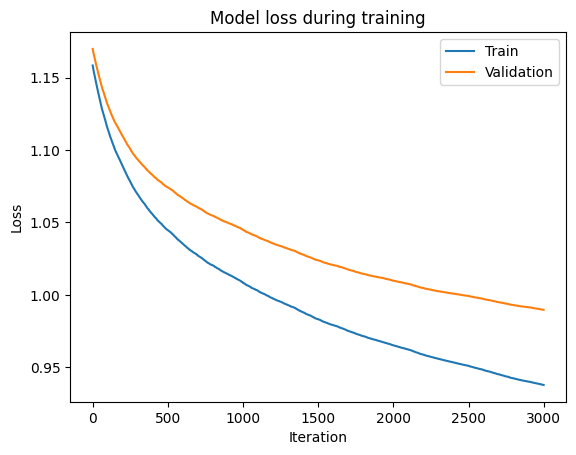

In [23]:
evals_result = model.get_evals_result()
evals_result
plt.plot(evals_result['learn']['RMSE'], label='Train')
plt.plot(evals_result['validation']['RMSE'], label='Validation')
plt.title('Model loss during training')
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.legend()
plt.show()

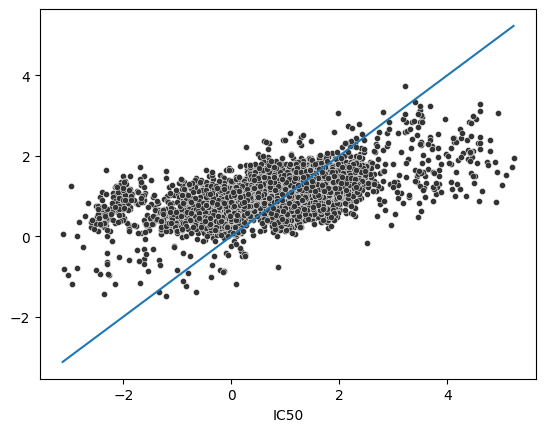

In [24]:
y_pred = model.predict(X_test)
sns.scatterplot(x=y_test, y=y_pred, s=20, color=".2")
sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], palette="deep");

In [25]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}')
print(f'R2 Score: {r2}')

MSE: 0.9096704777733771
R2 Score: 0.30037798859427634


In [39]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}')
print(f'R2 Score: {r2}')

MSE: 0.8032810090811202
R2 Score: 0.38152318842506194


In [ ]:
# ChemBert

# ChemBert

In [13]:
import torch
from transformers import AutoModelForMaskedLM, AutoTokenizer

chemberta = AutoModelForMaskedLM.from_pretrained("DeepChem/ChemBERTa-77M-MTR")
tokenizer = AutoTokenizer.from_pretrained("DeepChem/ChemBERTa-77M-MTR")

config.json:   0%|          | 0.00/17.7k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/14.0M [00:00<?, ?B/s]

Some weights of RobertaForMaskedLM were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['lm_head.bias', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/6.96k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/8.26k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/420 [00:00<?, ?B/s]

In [15]:
N = 1
smiles = df_filtered['SMILES'].iat[0]#[:30]
print('Len of smiles string:',len(smiles))
print(smiles)
with torch.no_grad():
    padding=True
    encoded_input = tokenizer(smiles, return_tensors="pt",padding=padding,truncation=True)
    model_output = chemberta(**encoded_input)
    print()
    print('model_output:')
    print('model_output info - type:', type(model_output),'len(model_output)', len(model_output) ,)
    print('type( model_output[0]):', type( model_output[0]), 'model_output[0].shape:',  model_output[0].shape  )
    print('model_output - first 100 symbols', str( model_output)[:100] )
    print()
    
    embedding = model_output[0][:,0,:]
    embeddings_cls = embedding
    print('embeddings_cls: type', type(embeddings_cls), 'shape:', embeddings_cls.shape)
    print()

    embedding = torch.mean(model_output[0],1)
    embeddings_mean = embedding
    print('embeddings_mean: type', type(embeddings_mean), 'shape:', embeddings_mean.shape)
    print()

Len of smiles string: 54
c1ccc(OC)cc1C(=O)c(c2-c3ccccc3)oc(c24)ccc5c4oc(=O)cc5C

model_output:
model_output info - type: <class 'transformers.modeling_outputs.MaskedLMOutput'> len(model_output) 1
type( model_output[0]): <class 'torch.Tensor'> model_output[0].shape: torch.Size([1, 56, 600])
model_output - first 100 symbols MaskedLMOutput(loss=None, logits=tensor([[[-0.4360,  0.0000,  0.3258,  ...,  0.1090,  0.2791,  0.703

embeddings_cls: type <class 'torch.Tensor'> shape: torch.Size([1, 600])

embeddings_mean: type <class 'torch.Tensor'> shape: torch.Size([1, 600])



In [16]:
from tqdm import tqdm

chemberta.eval()
def featurize_ChemBERTa(smiles_list, padding=True):
    embeddings_cls = torch.zeros(len(smiles_list), 600)
    embeddings_mean = torch.zeros(len(smiles_list), 600)

    with torch.no_grad():
        for i, smiles in enumerate(tqdm(smiles_list)):
            encoded_input = tokenizer(smiles, return_tensors="pt",padding=padding,truncation=True)
            model_output = chemberta(**encoded_input)
            
            embedding = model_output[0][::,0,::]
            embeddings_cls[i] = embedding
            
            embedding = torch.mean(model_output[0],1)
            embeddings_mean[i] = embedding
            
    return embeddings_cls.numpy(), embeddings_mean.numpy()

In [25]:
# N = int(1e4)
smiles_list = df_filtered['SMILES'].to_list()
# print(smiles_list[:10])
train_cls_pad_true, train_mean_pad_true = featurize_ChemBERTa(smiles_list)

100%|██████████| 35784/35784 [04:55<00:00, 121.06it/s]


In [9]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [55]:
cat_col = [col for col in df_filtered.columns if 'bit_id' in col]

In [57]:
df_filtered_chembert = df_filtered.drop(columns=cat_col)

In [60]:
for i in range(train_mean_pad_true.shape[1]):
    df_filtered_chembert[f'chem_{i}'] = train_mean_pad_true[:, i]

In [61]:
X = df_filtered_chembert[list(set(df_filtered_chembert.columns) - set(['Title', 'SMILES', 'IC50']))]
y = np.log(df_filtered_chembert['IC50'])

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.3, random_state=42)

In [72]:
model = CatBoostRegressor(task_type='GPU', 
#                           iterations=2000,
#                           learning_rate=0.003,
                          depth=9,
                          eval_metric='MAPE',
                          verbose=500)

model.fit(
    X_train,
    y_train,
    eval_set=(X_val, y_val),
#     cat_features=cat_col,
    use_best_model=True,
)

Learning rate set to 0.087939
0:	learn: 0.5411344	test: 0.5461008	best: 0.5461008 (0)	total: 293ms	remaining: 4m 52s
500:	learn: 0.3777745	test: 0.4837719	best: 0.4836709 (498)	total: 1m 14s	remaining: 1m 13s
999:	learn: 0.3296971	test: 0.4796631	best: 0.4796259 (997)	total: 2m 26s	remaining: 0us
bestTest = 0.4796259044
bestIteration = 997
Shrink model to first 998 iterations.


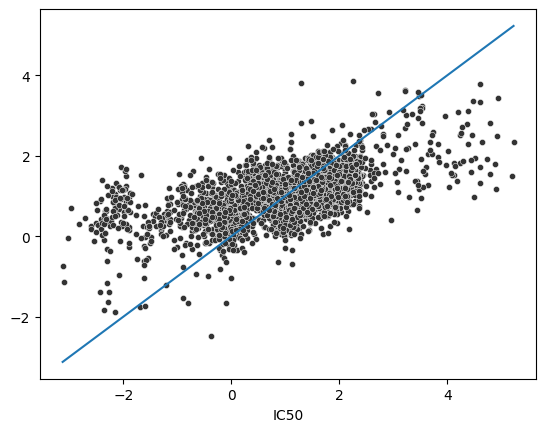

In [77]:
y_pred = model.predict(X_test)
sns.scatterplot(x=y_test, y=y_pred, s=20, color=".2")
sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], palette="deep");

In [78]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}')
print(f'R2 Score: {r2}')

MSE: 0.8582470455250908
R2 Score: 0.33920273197151507


# Classification

<Axes: xlabel='IC50', ylabel='Count'>

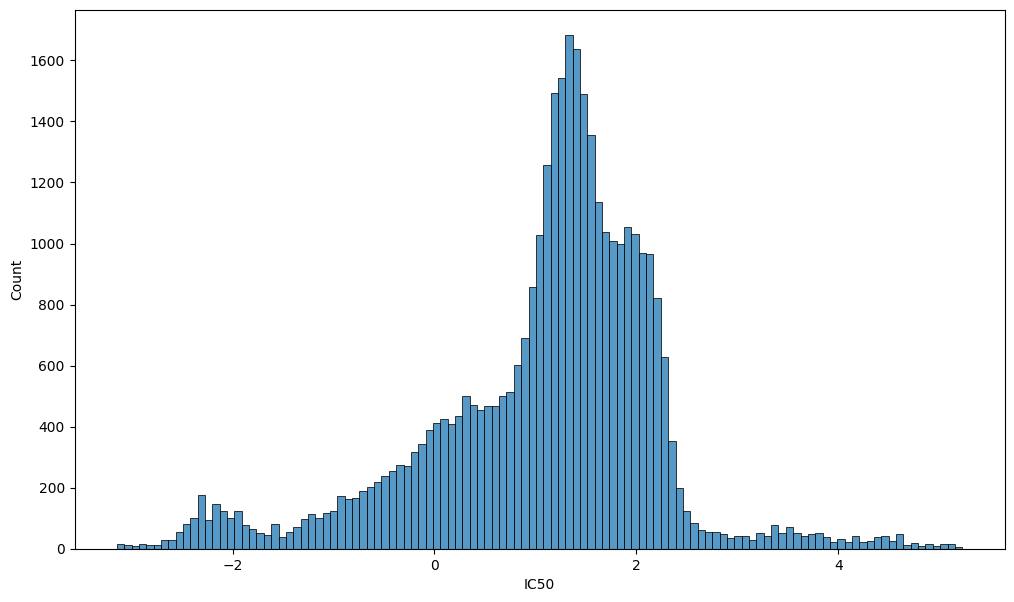

In [10]:
plt.figure(figsize=(12, 7))
sns.histplot(np.log(df_filtered['IC50']))

In [11]:
n = 4

In [12]:
def return_center(values, n):
    values = np.log(values)
    dict_center = {}
    for i, interval in enumerate(pd.qcut(values, n).value_counts().index.sort_values()):
#         print(interval)
        dict_center[i] = interval.right - (interval.right - interval.left) / 2
    return dict_center
       
dict_center = return_center(df_filtered['IC50'], n)

In [13]:
df_filtered['Interval'] = pd.qcut(np.log(df_filtered['IC50']), n, labels=False)

In [14]:
df_filtered['Interval'].value_counts()

Interval
1    8952
0    8946
2    8943
3    8943
Name: count, dtype: int64

In [15]:
X = df_filtered[list(set(df_filtered.columns) - set(['Title', 'SMILES', 'IC50', 'Interval']))]
y = df_filtered[['Interval', 'IC50']]

In [16]:
cat_col = [col for col in df_filtered.columns if 'bit_id' in col]

In [17]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import mean_squared_error, r2_score

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size=0.3, 
                                                    stratify=y['Interval'],
                                                    random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, 
                                                y_test, 
                                                test_size=0.5, 
                                                stratify=y_test['Interval'],
                                                random_state=42)

In [24]:
model = CatBoostClassifier(task_type='GPU', 
#                           iterations=2000,
#                           learning_rate=0.003,
                          depth=3,
#                           eval_metric='MAPE',
                          verbose=500)

model.fit(
    X_train,
    y_train['Interval'],
    eval_set=(X_val, y_val['Interval']),
#     cat_features=cat_col,
    use_best_model=True,
)

Learning rate set to 0.145582
0:	learn: 1.3652498	test: 1.3647192	best: 1.3647192 (0)	total: 10.8ms	remaining: 10.8s
500:	learn: 1.0924116	test: 1.1494174	best: 1.1494174 (500)	total: 4.76s	remaining: 4.74s
999:	learn: 1.0300710	test: 1.1333454	best: 1.1331867 (993)	total: 7.5s	remaining: 0us
bestTest = 1.133186716
bestIteration = 993
Shrink model to first 994 iterations.


In [26]:
importances = model.get_feature_importance(type='PredictionValuesChange')
feature_importances = pd.Series(importances, index=X.columns).sort_values()
feature_importances

bit_id_902                   0.000000
bit_id_1075                  0.000000
bit_id_1399                  0.000000
bit_id_40                    0.000000
bit_id_1180                  0.000000
                              ...    
NumAromaticRings             3.048681
MR                           3.233454
NumAliphaticHeterocycles     3.606071
NumValenceElectrons          5.149228
MW                          13.350714
Length: 2063, dtype: float64

In [27]:
y_pred = model.predict(X_test)

In [28]:
from sklearn.metrics import classification_report

print(classification_report(y_test['Interval'], y_pred))

              precision    recall  f1-score   support

           0       0.59      0.56      0.58      1342
           1       0.50      0.51      0.50      1343
           2       0.38      0.38      0.38      1342
           3       0.47      0.48      0.48      1341

    accuracy                           0.48      5368
   macro avg       0.48      0.48      0.48      5368
weighted avg       0.48      0.48      0.48      5368



# Save photo

In [241]:
from rdkit import Chem
from rdkit.Chem import Draw


for i in tqdm(range(df_filtered.shape[0])):
    smiles = df_filtered.iloc[i]['SMILES']
    label = df_filtered.iloc[i]['Interval']                                                        
    mol = Chem.MolFromSmiles(smiles)
    img = Draw.MolToImage(mol)
    img.save(f"/kaggle/working/draw_new/{label}/{i}.png")


  0%|          | 0/35784 [00:00<?, ?it/s]

[18:30:08] Conflicting single bond directions around double bond at index 7.
[18:30:08]   BondStereo set to STEREONONE and single bond directions set to NONE.


In [239]:
import os

for i in range(n):
    name = f"/kaggle/working/draw_new/{i}"
    if not os.path.isdir(name):
         os.mkdir(name)

In [228]:
df_filtered.iloc[0]

Title                                                  CHEMBL600808
IC50                                                       0.045147
SMILES            c1ccc(OC)cc1C(=O)c(c2-c3ccccc3)oc(c24)ccc5c4oc...
HeavyAtomCount                                                 31.0
NHOHCount                                                       0.0
                                        ...                        
bit_id_2044                                                       0
bit_id_2045                                                       0
bit_id_2046                                                       0
bit_id_2047                                                       0
Interval                                                          0
Name: 57, Length: 2067, dtype: object